In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from construct import *

import sys
sys.path.append('../Tianwen')
import ccsds

import collections
import datetime
import struct
import subprocess
import warnings

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def load_frames(file):
    frame_size = 223 * 5
    frames = np.fromfile(file, dtype = 'uint8')
    return frames[:frames.size//frame_size*frame_size].reshape(-1, frame_size)

#frames = load_frames('stereo-a_bg2bhc_frames_20220924_0710.raw')
frames = load_frames('stereo-a_bg2bhc_frames_20220924_1035.raw')

## TM Primary Headers

The frames are TM Space Data Link frames. The spacecraft ID is 234 (0xEA). Virtual channels 0 and 7 are in use. OCF and secondary headers are used.

In [3]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

TransferFrameSecondaryHeaderId = BitStruct(
    'version_number' / BitsInteger(2),
    'header_length' / BitsInteger(6)
)

CLCW = BitStruct(
    'control_word_type' / Flag,
    'clcw_version_number' / BitsInteger(2),
    'status_field' / BitsInteger(3),
    'cop_in_effect' / BitsInteger(2),
    'virtual_channel_identification' / BitsInteger(6),
    'rsvd_spare' / BitsInteger(2),
    'no_rf_avail' / Flag,
    'no_bit_lock' / Flag,
    'lock_out' / Flag,
    'wait' / Flag,
    'retransmit' / Flag,
    'farm_b_counter' / BitsInteger(2),
    'rsvd_spare2' / BitsInteger(1),
    'report_value' / BitsInteger(8)
)

In [4]:
tm = [TMPrimaryHeader.parse(f) for f in frames]
scid = np.array([h.spacecraft_id for h in tm])
vcid = np.array([h.virtual_channel_id for h in tm])
v_framecount = np.array([h.virtual_channel_frame_count for h in tm])
m_framecount = np.array([h.master_channel_frame_count for h in tm])

In [5]:
tm[:5]

[Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=32, virtual_channel_frame_count=251, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=33, virtual_channel_frame_count=252, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=34, virtual_channel_frame_count=253, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=35, virtual_channel_frame_coun

In [6]:
collections.Counter(scid)

Counter({234: 94})

In [7]:
collections.Counter(vcid)

Counter({7: 88, 0: 6})

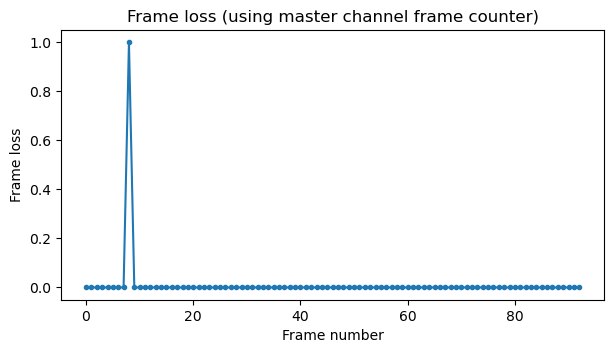

In [8]:
plt.plot(np.diff(m_framecount) - 1, '.-')
plt.title('Frame loss (using master channel frame counter)')
plt.ylabel('Frame loss')
plt.xlabel('Frame number');

## TM Secondary Header

The TM Secondary Header contains a timestamp giving the seconds since 2006-10-25 12:00 UTC as a 32-bit integer, plus an additional 8-bit integer that counts 1/256-ths of a second. The remaining 9 bytes of the header are filled with `0x00` in the virtual channel 7 frames and with `0xff` in the virtual channel 0 frames.

In [9]:
sec_header_id = [TransferFrameSecondaryHeaderId.parse(f[TMPrimaryHeader.sizeof():])
                 for f in frames]
all([sec_header_id[0] == h for h in sec_header_id])

True

In [10]:
sec_header_id[0]

Container(version_number=0, header_length=14)

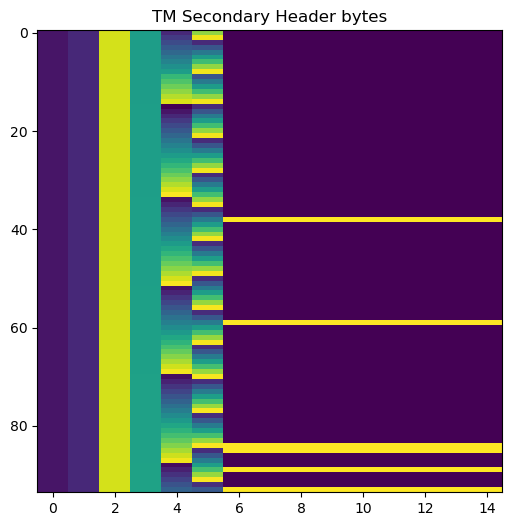

In [11]:
plt.figure(figsize=(6, 6))
plt.imshow(frames[:, 6:6+15], interpolation='none', aspect='auto')
plt.title('TM Secondary Header bytes');

In [12]:
np.all(frames[vcid != 0, 12:6+15] == 0)

True

In [13]:
np.all(frames[vcid == 0, 12:6+15] == 0xff)

True

In [14]:
timestamps_secs = (
    frames[:, 7:11].view('uint32').byteswap().ravel().astype('float')
    + frames[:, 11].astype('float') / 256)

In [15]:
np.diff(timestamps_secs)

array([14.140625  , 14.14453125, 14.14453125, 14.140625  , 14.14453125,
       14.140625  , 14.14453125, 14.14453125, 28.28515625, 14.14453125,
       14.140625  , 14.14453125, 14.140625  , 14.14453125, 14.14453125,
       14.140625  , 14.14453125, 14.140625  , 14.14453125, 14.14453125,
       14.140625  , 14.14453125, 14.140625  , 14.14453125, 14.14453125,
       14.140625  , 14.14453125, 14.14453125, 14.140625  , 14.14453125,
       14.140625  , 14.14453125, 14.14453125, 14.140625  , 14.14453125,
       14.140625  , 14.14453125, 14.14453125, 14.140625  , 14.14453125,
       14.140625  , 14.14453125, 14.14453125, 14.140625  , 14.14453125,
       14.14453125, 14.140625  , 14.14453125, 14.140625  , 14.14453125,
       14.14453125, 14.140625  , 14.14453125, 14.140625  , 14.14453125,
       14.14453125, 14.140625  , 14.14453125, 14.14453125, 14.140625  ,
       14.14453125, 14.140625  , 14.14453125, 14.14453125, 14.140625  ,
       14.14453125, 14.140625  , 14.14453125, 14.14453125, 14.14

In [16]:
(5*223*8 + 4 + 32) * 6 / 3.8e3

14.141052631578948

In [17]:
1/256

0.00390625

In [18]:
datetime.datetime(2022, 9, 24, 10, 35, 0) - datetime.timedelta(seconds=timestamps_secs[0])

datetime.datetime(2006, 10, 25, 11, 49, 10, 167969)

In [19]:
epoch = np.datetime64('2006-10-25T12:00:00')

In [20]:
timestamps = epoch + np.timedelta64(1, 'ns') * (timestamps_secs * 1e9)

In [21]:
timestamps[0]

numpy.datetime64('2022-09-24T10:45:49.832031232')

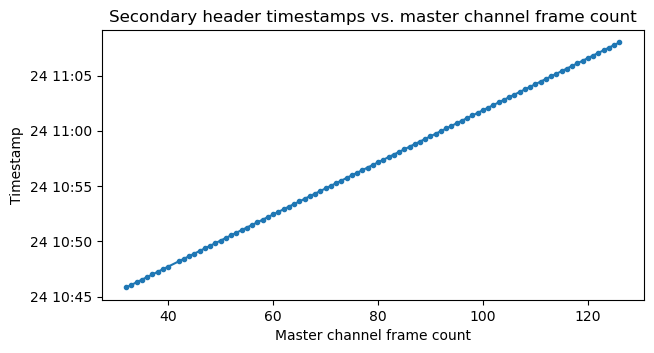

In [22]:
plt.plot(m_framecount, timestamps, '.-')
plt.title('Secondary header timestamps vs. master channel frame count')
plt.xlabel('Master channel frame count')
plt.ylabel('Timestamp');

## Operational Control Field

The operational control field shows receiver lock, event though the frequency of the downlink transmitter changes during the recording (indicating loss of ground lock).

In [23]:
ocf = frames[:, -6:-2]
np.all(ocf == ocf[0])

True

In [24]:
print(CLCW.parse(ocf[0]))

Container: 
    control_word_type = False
    clcw_version_number = 0
    status_field = 0
    cop_in_effect = 1
    virtual_channel_identification = 2
    rsvd_spare = 0
    no_rf_avail = False
    no_bit_lock = False
    lock_out = False
    wait = False
    retransmit = False
    farm_b_counter = 2
    rsvd_spare2 = 0
    report_value = 234


## Virtual channel 0

Frames in virtual channel 0 carry OID (only idle data). The transfer frame data field is filled with `0xff` bytes.

In [25]:
[h for h in tm if h.virtual_channel_id == 0]

[Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=71, virtual_channel_frame_count=4, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=92, virtual_channel_frame_count=5, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=117, virtual_channel_frame_count=6, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=234, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=118, virtual_channel_frame

In [26]:
np.all(frames[vcid == 0][:, 12:-6] == 0xff)

True

## Virtual channel 7

Frames in virtual channel 7 contain 4 Space Packets with a length of 272 bytes (which divides the transfer frame data field evenly in 4). The Space Packets in the non-idle APIDs have a Secondary Header with a 32-bit timestamp giving the number of seconds since the CCSDS time code epoch 1958-01-01 00:00:00 TAI.

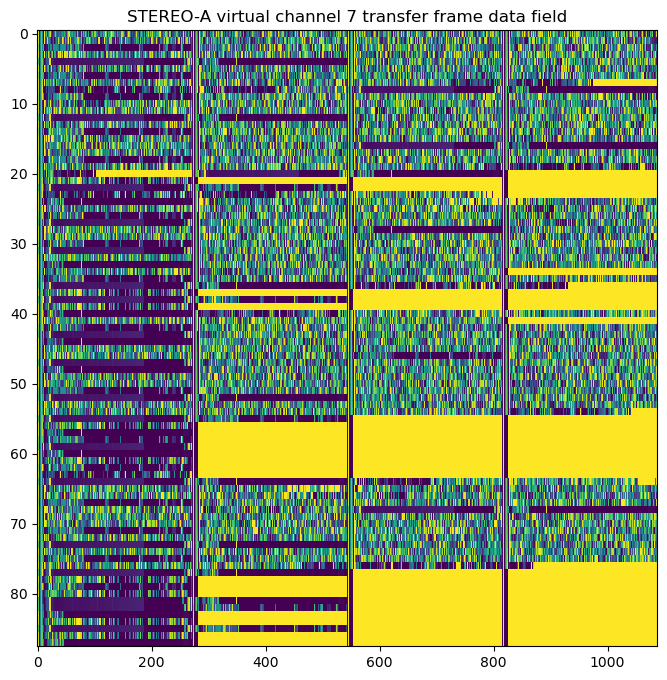

In [27]:
plt.figure(figsize=(8, 8))
plt.imshow(frames[vcid == 7, 6+15:-6], interpolation='none', aspect='auto')
plt.title('STEREO-A virtual channel 7 transfer frame data field');

In [28]:
# 265 bytes = Space Packet data length field (indicates length-1)
# 6 bytes = Space Packet primary header
# 4 Space Packets per TM frame
# 6 bytes = TM Primary Header
# 15 bytes = TM Secondary Header
# 4 bytes = OCF (CLCW)
# 2 bytes = FECF (CRC-16)
(265 + 1 + 6) * 4 + 6 + 15 + 4 + 2 == frames.shape[1]

True

In [29]:
packet_len = 265 + 1 + 6

In [30]:
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(f[6+15+k*packet_len:])
                  for f in frames[vcid == 7] for k in range(4)]

In [31]:
packet_headers[:5]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1137, sequence_flags=3, packet_sequence_count_or_name=13583, data_length=265),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1137, sequence_flags=3, packet_sequence_count_or_name=13584, data_length=265),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1137, sequence_flags=3, packet_sequence_count_or_name=13585, data_length=265),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1137, sequence_flags=3, packet_sequence_count_or_name=13586, data_length=265),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1137, sequence_flags=3, packet_sequence_count_or_name=13587, data_length=265)]

In [32]:
collections.Counter([h.ccsds_version for h in packet_headers])

Counter({0: 352})

In [33]:
collections.Counter([h.packet_type for h in packet_headers])

Counter({0: 352})

In [34]:
collections.Counter([h.secondary_header_flag for h in packet_headers])

Counter({True: 280, False: 72})

In [35]:
collections.Counter([h.APID for h in packet_headers])

Counter({1140: 128, 1137: 77, 2047: 72, 624: 22, 1393: 22, 880: 22, 0: 9})

In [36]:
apids = {h.APID for h in packet_headers}
{apid: collections.Counter([
    h.secondary_header_flag
    for h in packet_headers if h.APID == apid]) for apid in apids}

{0: Counter({True: 9}),
 624: Counter({True: 22}),
 1137: Counter({True: 77}),
 880: Counter({True: 22}),
 1393: Counter({True: 22}),
 1140: Counter({True: 128}),
 2047: Counter({False: 72})}

In [37]:
collections.Counter([h.sequence_flags for h in packet_headers])

Counter({3: 352})

In [38]:
collections.Counter([h.data_length for h in packet_headers])

Counter({265: 352})

In [39]:
space_packets = [f[6+15+k*packet_len:][:packet_len]
                 for f in frames[vcid == 7] for k in range(4)]
by_apid = {apid: [] for apid in apids}
for packet, header in zip(space_packets, packet_headers):
    by_apid[header.APID].append(packet)
by_apid = {apid: np.array(by_apid[apid]) for apid in apids}

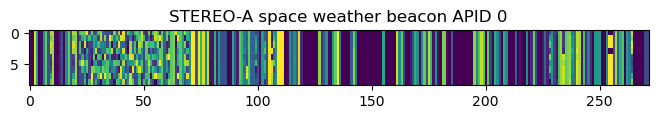

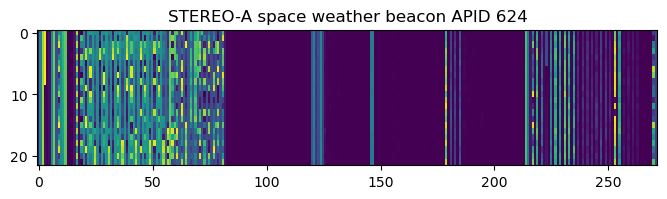

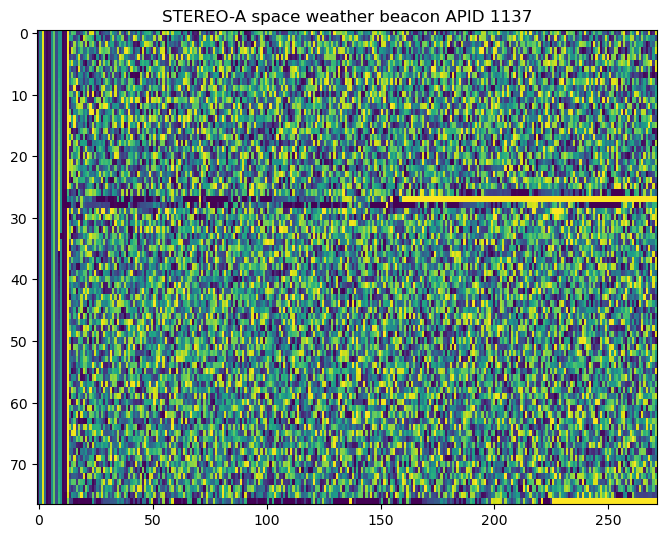

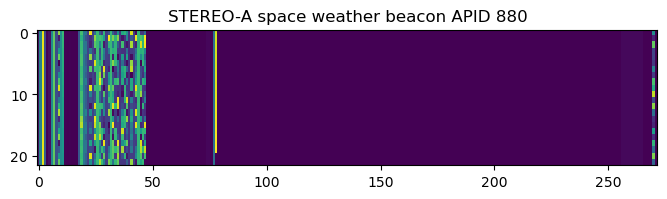

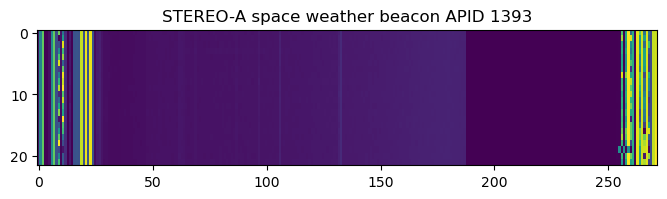

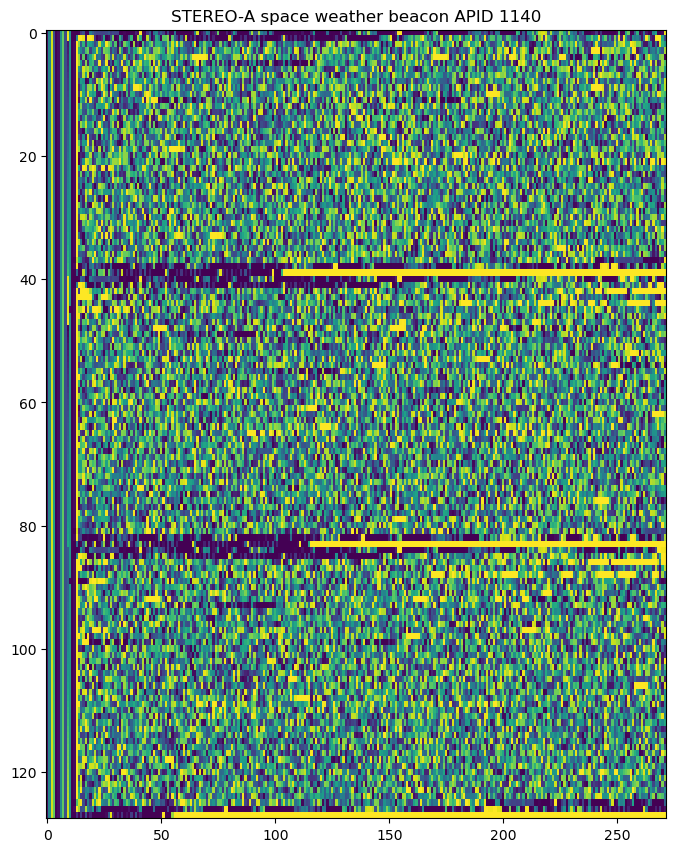

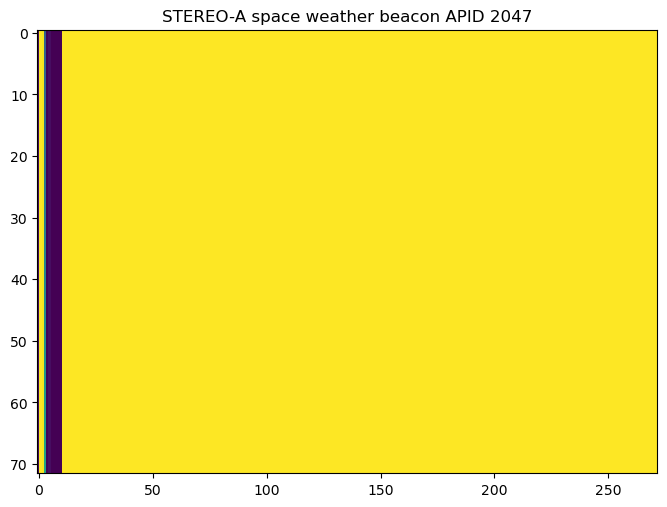

In [40]:
for apid in apids:
    data = by_apid[apid]
    plt.figure(figsize=(8, 8 * data.shape[0] / 100))
    plt.imshow(data, interpolation='none', aspect='auto')
    plt.title(f'STEREO-A space weather beacon APID {apid}')

In [41]:
non_idle = [h.APID != 2047 for h in packet_headers]
packet_timestamps_secs = np.array(space_packets)[non_idle, 6:10].view('uint32').byteswap().ravel()

In [42]:
datetime.datetime(2022, 9, 24, 10, 35, 0) - datetime.timedelta(seconds=int(packet_timestamps_secs[0]))

datetime.datetime(1958, 1, 1, 0, 5, 42)

In [43]:
ccsds_epoch = np.datetime64('1958-01-01T00:00:00')
packet_timestamps = ccsds_epoch + np.timedelta64(1, 's') * packet_timestamps_secs
packet_timestamps[0]

numpy.datetime64('2022-09-24T10:29:18')

In [44]:
apids_for_timestamps = np.array([h.APID for h in packet_headers if h.APID != 2047])
tmtimestaps_for_timestamps = np.repeat(timestamps[vcid == 7], 4)[non_idle]

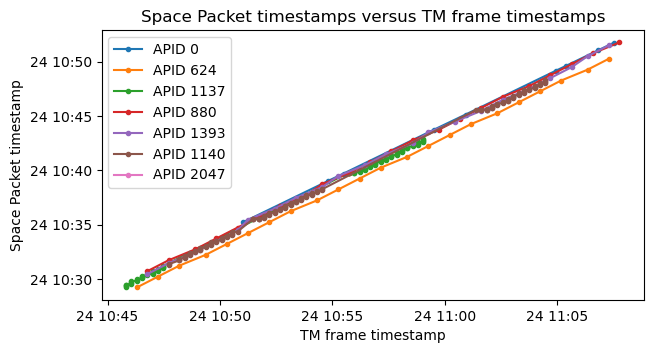

In [45]:
for apid in apids:
    sel = apids_for_timestamps == apid
    plt.plot(tmtimestaps_for_timestamps[sel], packet_timestamps[sel], '.-',
             label=f'APID {apid}')
plt.legend()
plt.title('Space Packet timestamps versus TM frame timestamps')
plt.xlabel('TM frame timestamp')
plt.ylabel('Space Packet timestamp');

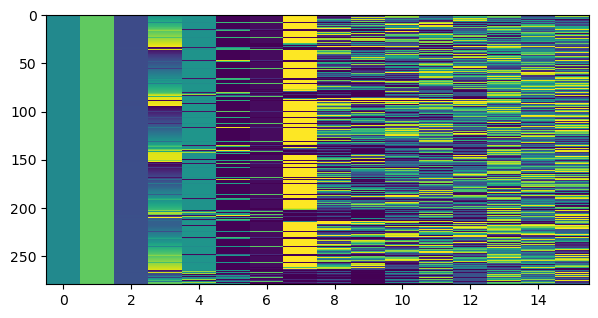

In [46]:
plt.imshow(np.array(space_packets)[non_idle, 6:6+16], aspect='auto', interpolation='none');

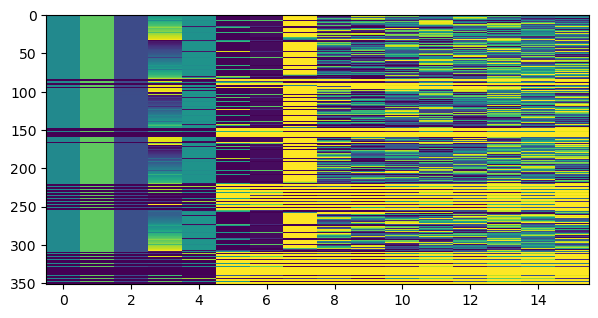

In [47]:
plt.imshow(np.array(space_packets)[:, 6:6+16], aspect='auto', interpolation='none');

## S/WAVES beacon data

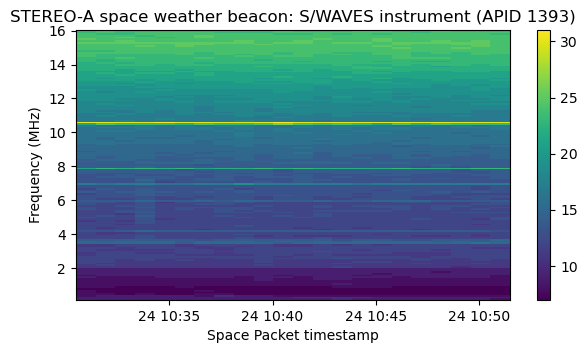

In [48]:
swaves_data = by_apid[1393][:, 29:29+159]
swaves_timestamps = packet_timestamps[apids_for_timestamps == 1393]

plt.imshow(swaves_data.T[::-1], aspect='auto', interpolation='none',
           extent=[mdates.date2num(swaves_timestamps[0]),
                   mdates.date2num(swaves_timestamps[-1]),
                   0.125, 16.025,])
plt.gca().xaxis_date()
plt.colorbar()
plt.title('STEREO-A space weather beacon: S/WAVES instrument (APID 1393)')
plt.xlabel('Space Packet timestamp')
plt.ylabel('Frequency (MHz)');

In [49]:
swaves_timestamps

array(['2022-09-24T10:30:29', '2022-09-24T10:31:29',
       '2022-09-24T10:32:29', '2022-09-24T10:33:29',
       '2022-09-24T10:34:29', '2022-09-24T10:35:29',
       '2022-09-24T10:36:29', '2022-09-24T10:37:29',
       '2022-09-24T10:38:29', '2022-09-24T10:39:29',
       '2022-09-24T10:40:29', '2022-09-24T10:41:29',
       '2022-09-24T10:42:29', '2022-09-24T10:43:29',
       '2022-09-24T10:44:29', '2022-09-24T10:45:29',
       '2022-09-24T10:46:29', '2022-09-24T10:47:29',
       '2022-09-24T10:48:29', '2022-09-24T10:49:29',
       '2022-09-24T10:50:29', '2022-09-24T10:51:29'],
      dtype='datetime64[s]')

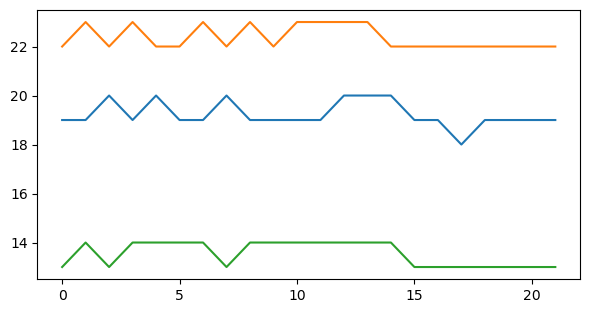

In [50]:
plt.plot(by_apid[1393][:, 26:29]);

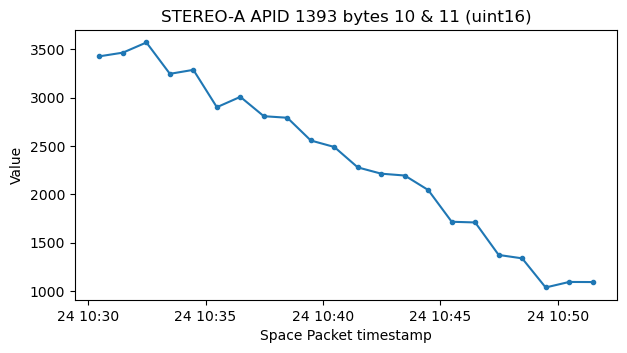

In [51]:
plt.plot(swaves_timestamps, by_apid[1393][:, 10:12].view('uint16').byteswap(), '.-')
plt.title('STEREO-A APID 1393 bytes 10 & 11 (uint16)')
plt.ylabel('Value')
plt.xlabel('Space Packet timestamp');

In [52]:
packet_timestamps[apids_for_timestamps == 0]

array(['2022-09-24T10:35:14', '2022-09-24T10:39:01',
       '2022-09-24T10:39:43', '2022-09-24T10:43:44',
       '2022-09-24T10:45:08', '2022-09-24T10:49:09',
       '2022-09-24T10:49:37', '2022-09-24T10:51:02',
       '2022-09-24T10:51:44'], dtype='datetime64[s]')

## SECCHI data

In [53]:
SECCHIBlockHeader = BitStruct(
    'padding' / Padding(5),
    'image_count' / BitsInteger(11),
    'block_type' / BitsInteger(2),
    'block_number' / BitsInteger(14),
    'block_length' / BitsInteger(16)
)

def check_secchi_block(block):
    if len(block) < SECCHIBlockHeader.sizeof():
        warnings.warn('SECCHI block too short')
        return False
    header = SECCHIBlockHeader.parse(block)
    expected = header.block_length + 1 + SECCHIBlockHeader.sizeof()
    if len(block) != expected:
        warnings.warn(f'SECCHI block has incorrect size. Expected {expected}; has {len(block)}')
        return False
    return True

def extract_secchi_blocks(space_packets):
    block = bytearray()
    seq_count = None
    for packet in space_packets:       
        packet_header = ccsds.SpacePacketPrimaryHeader.parse(packet)
        seq_count_new = packet_header.packet_sequence_count_or_name
        if seq_count is not None \
          and seq_count_new != ((seq_count + 1) % 2**14):
            warnings.warn(f'[SECCHI block extractor] Broken stream. '
                          f'Last seq count {seq_count}, '
                          f'current seq count {seq_count_new}')
            block = bytearray()
        seq_count = seq_count_new

        first = struct.unpack('>H', packet[12:14])[0]
        if first == 0x7ff:
            # no packet starts
            if block:
                block.extend(packet[14:])
            continue
        
        if block:
            block.extend(packet[14:][:first])
            block = bytes(block)
            if check_secchi_block(block):
                yield block

        while True:
            block = bytearray(packet[14:][first:][:SECCHIBlockHeader.sizeof()])
            if len(block) < SECCHIBlockHeader.sizeof():
                # not full block header inside frame
                break
            first += SECCHIBlockHeader.sizeof()
            block_header = SECCHIBlockHeader.parse(block)
            block.extend(packet[14:][first:][:block_header.block_length + 1])
            first += block_header.block_length + 1
            if first > len(packet[14:]):
                # block does not end in this frame
                break
            block = bytes(block)
            if check_secchi_block(block):
                yield block
            block = bytearray()
            if first == len(packet[14:]):
                # block just ends in this frame
                break

def display_secchi_images(blocks, vertical_flip=False):
    for block in blocks:
        header = SECCHIBlockHeader.parse(block)
        if header.block_type == 0 and header.image_count != 2047:
            with open('/tmp/secchi_compressed', 'wb') as f:
                f.write(block[SECCHIBlockHeader.sizeof():])
            subprocess.run(['./idecomp.linux', '-i', '/tmp/secchi_compressed',
                            '-o', '/tmp/secchi_decompressed'])
        
            img = np.fromfile('/tmp/secchi_decompressed', 'uint16')
            size = int(np.sqrt(img.size))
            img = img.reshape(size, size).T
            if vertical_flip:
                img = img[::-1]
            plt.figure(figsize=(5, 5))
            plt.imshow(img, cmap='inferno', vmin=0, vmax=np.max(img))

In [54]:
blocks = list(extract_secchi_blocks([bytes(p) for p in by_apid[1137]]))
[SECCHIBlockHeader.parse(block) for block in blocks]

[Container(padding=None, image_count=806, block_type=2, block_number=2, block_length=215),
 Container(padding=None, image_count=2047, block_type=0, block_number=0, block_length=111),
 Container(padding=None, image_count=879, block_type=1, block_number=0, block_length=215),
 Container(padding=None, image_count=879, block_type=0, block_number=1, block_length=12139),
 Container(padding=None, image_count=879, block_type=2, block_number=2, block_length=215),
 Container(padding=None, image_count=2047, block_type=0, block_number=0, block_length=45)]

Status word:        0
Apparent bit depth: 14


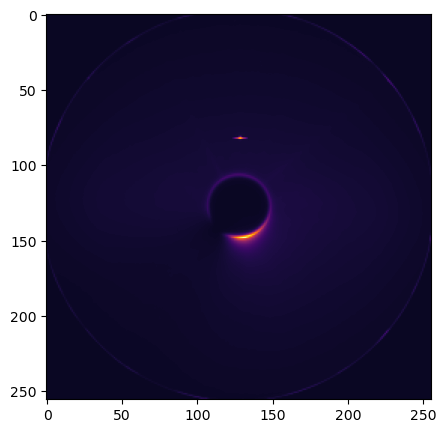

In [55]:
display_secchi_images(blocks)

In [56]:
blocks = list(extract_secchi_blocks([bytes(p) for p in by_apid[1140]]))
[SECCHIBlockHeader.parse(block) for block in blocks]

/tmp/ipykernel_66751/150766877.py:28: UserWarning: [SECCHI block extractor] Broken stream. Last seq count 11839, current seq count 11844
  warnings.warn(f'[SECCHI block extractor] Broken stream. '


[Container(padding=None, image_count=810, block_type=1, block_number=0, block_length=363),
 Container(padding=None, image_count=810, block_type=2, block_number=2, block_length=363),
 Container(padding=None, image_count=2047, block_type=0, block_number=0, block_length=167),
 Container(padding=None, image_count=858, block_type=1, block_number=0, block_length=363),
 Container(padding=None, image_count=858, block_type=0, block_number=1, block_length=10443),
 Container(padding=None, image_count=858, block_type=2, block_number=2, block_length=363),
 Container(padding=None, image_count=2047, block_type=0, block_number=0, block_length=155),
 Container(padding=None, image_count=901, block_type=1, block_number=0, block_length=363),
 Container(padding=None, image_count=901, block_type=0, block_number=1, block_length=10383),
 Container(padding=None, image_count=901, block_type=2, block_number=2, block_length=363),
 Container(padding=None, image_count=2047, block_type=0, block_number=0, block_lengt

Status word:        0
Apparent bit depth: 13
Status word:        0
Apparent bit depth: 13


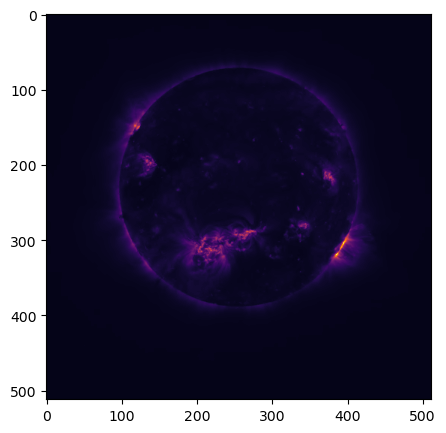

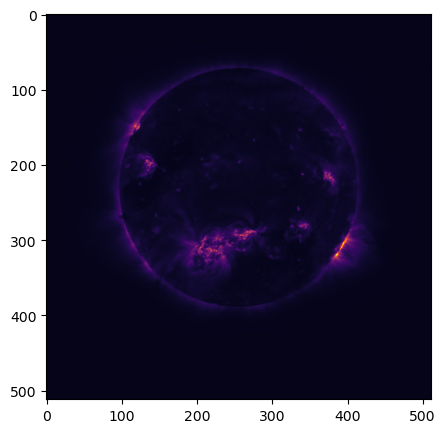

In [57]:
display_secchi_images(blocks, vertical_flip=True)